## Object detection on the birds dataset.
### Details on the dataset
[Caltech Birds (CUB 200 2011)](https://paperswithcode.com/dataset/cub-200-2011)

RecordIO format is used for training data.

### Model 
Using Sagemaker's object detection algorithm using Single shot multibox detector (SSD). With a ResNet network.

In [1]:
!pip install --upgrade pip
!pip install boto --upgrade
!pip install boto3 --upgrade
!pip install awscli --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 36.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: awscli
    Found existing installation: awscli 1.27.35
    Uninstalling awscli-1.27.35:
      Successfully uninstalled awscli-1.27.35


In [2]:
# These packages are needed to use OpenCV in Studio as of February 2022
import platform
if platform.libc_ver()[0] == "debian":
    ! apt-get update
    ! apt-get install ffmpeg libsm6 libxext6  -y

In [3]:
import sys

!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-ObjectDetection-birds"

print("s3://{}/{}/".format(bucket, prefix))

s3://sagemaker-eu-west-1-636444261840/DEMO-ObjectDetection-birds/


In [5]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::636444261840:role/service-role/AmazonSageMaker-ExecutionRole-20221227T094171


## Data preparation

In [6]:
import os
import urllib.request


def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [7]:
%%time
# download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')
# CalTech's download is (at least temporarily) unavailable since August 2020.

# Can now use one made available by fast.ai .
download("https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz")

CPU times: user 1.94 s, sys: 2.55 s, total: 4.5 s
Wall time: 28.6 s


In [8]:
%%time
# Clean up prior version of the downloaded dataset if you are running this again
!rm -rf CUB_200_2011

# Unpack and then remove the downloaded compressed tar file
!gunzip -c ./CUB_200_2011.tgz | tar xopf -
!rm CUB_200_2011.tgz

rm: cannot remove ‘CUB_200_2011.tgz’: No such file or directory
CPU times: user 144 ms, sys: 33 ms, total: 178 ms
Wall time: 11.2 s


## Explore the dataset

In [9]:
import pandas as pd
import cv2
import boto3
import json

runtime = boto3.client(service_name="runtime.sagemaker")

import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_SPLIT = False
SAMPLE_ONLY = True
FLIP = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [17, 36, 47, 68, 73]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR = "CUB_200_2011/"
IMAGES_DIR = BASE_DIR + "images/"

CLASSES_FILE = BASE_DIR + "classes.txt"
BBOX_FILE = BASE_DIR + "bounding_boxes.txt"
IMAGE_FILE = BASE_DIR + "images.txt"
LABEL_FILE = BASE_DIR + "image_class_labels.txt"
SIZE_FILE = BASE_DIR + "sizes.txt"
SPLIT_FILE = BASE_DIR + "train_test_split.txt"

TRAIN_LST_FILE = "birds_ssd_train.lst"
VAL_LST_FILE = "birds_ssd_val.lst"

if SAMPLE_ONLY:
    TRAIN_LST_FILE = "birds_ssd_sample_train.lst"
    VAL_LST_FILE = "birds_ssd_sample_val.lst"

TRAIN_RATIO = 0.8
CLASS_COLS = ["class_number", "class_id"]
IM2REC_SSD_COLS = [
    "header_cols",
    "label_width",
    "zero_based_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "image_file_name",
]

Matplotlib is building the font cache; this may take a moment.


In [10]:
def show_species(species_id):
    """
    Shows all images in dataset for a given species_id
    args: species_id
    """
    # internal list in scope of function
    _im_list = !ls $IMAGES_DIR/$species_id

    NUM_COLS = 6
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')

    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(8.0, 16.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo number of rows
        # is plotting rowwise.
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()
    plt.show()

    # Clean up
    plt.clf() # clean figure
    plt.cla() # clean axes
    plt.close() 

Species 001.Black_footed_Albatross has 60 images.


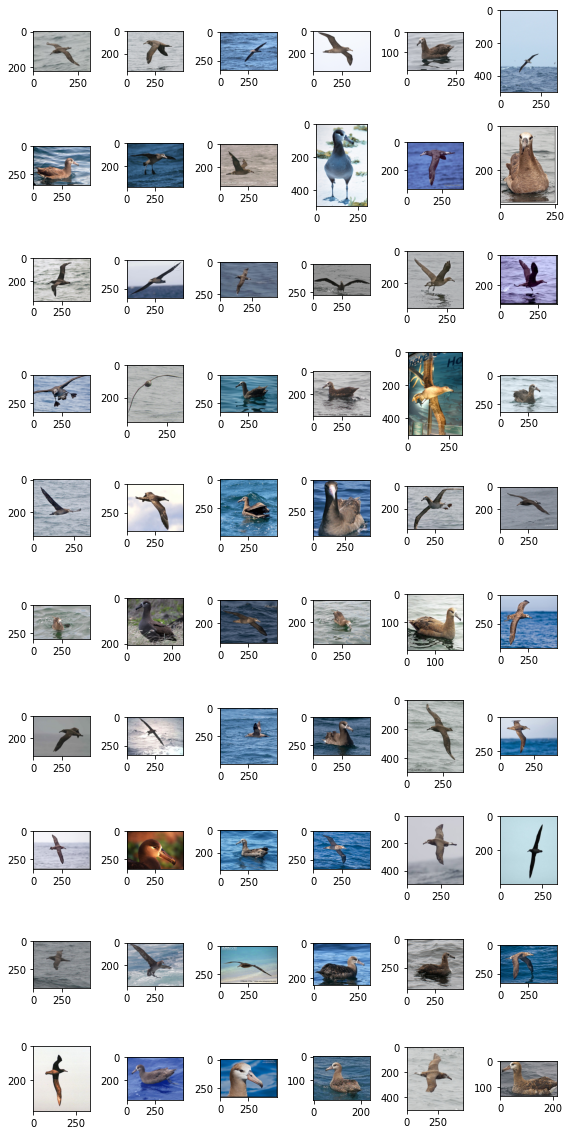

In [11]:
show_species('001.Black_footed_Albatross')

### (Aside) Recommended way to now plot an image

```python
from PIL import Image

example_img = IMAGES_DIR + '001.Black_footed_Albatross/' + _im_list[0]

with Image.open(example_img) as im:
    im.show()
```

In [12]:
classes_df = pd.read_csv(CLASSES_FILE, sep=" ", names=CLASS_COLS, header=None)
criteria = classes_df["class_number"].isin(CLASSES)
classes_df = classes_df[criteria]
print(classes_df.to_csv(columns=["class_id"], sep="\t", index=False, header=False))

017.Cardinal
036.Northern_Flicker
047.American_Goldfinch
068.Ruby_throated_Hummingbird
073.Blue_Jay



## Generate RecordIO Files
The bounding box annotations in `CUB_200_2011/bounding_boxes.txt` are in absolute terms. So they will also have to be resized along with the images using the same scaling factor. Here we calculate the size of the images.


In [17]:
from ipywidgets import IntProgress

In [18]:
%%time
SIZE_COLS = ["idx", "width", "height"]


def gen_image_size_file():
    print("Generating a file containing image sizes...")
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    rows_list = []
    idx = 0
    f = IntProgress(idx=0, max=images_df.shape[0]) # instantiate the bar
    display(f) # display the bar
    for i in images_df["image_file_name"]:
        f.value += 1
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        dimensions = img.shape
        height = img.shape[0]
        width = img.shape[1]
        image_dict = {"idx": idx, "width": width, "height": height}
        rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print("Image sizes:\n" + str(sizes_df.head(5)))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=" ", index=False, header=None)
    


gen_image_size_file()

Generating a file containing image sizes...


IntProgress(value=0, max=11788)

Image sizes:
   idx  width  height
0    1    500     335
1    2    500     336
2    3    500     347
3    4    415     500
4    5    331     380
CPU times: user 1min 5s, sys: 2.82 s, total: 1min 8s
Wall time: 1min 14s


In [20]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print(
            "\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}".format(
                lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)
            )
        )
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df


def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(
        SIZE_FILE, sep=" ", names=["image_pretty_name", "width", "height"], header=None
    )
    bboxes_df = pd.read_csv(
        BBOX_FILE,
        sep=" ",
        names=["image_pretty_name", "x_abs", "y_abs", "bbox_width", "bbox_height"],
        header=None,
    )
    split_df = pd.read_csv(
        SPLIT_FILE, sep=" ", names=["image_pretty_name", "is_training_image"], header=None
    )
    print(IMAGE_FILE)
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    print("num images total: " + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(
        LABEL_FILE, sep=" ", names=["image_pretty_name", "class_id"], header=None
    )

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on="image_pretty_name")
    full_df = pd.merge(full_df, sizes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, bboxes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, split_df, on="image_pretty_name")
    full_df.sort_values(by=["index"], inplace=True)

    # Define the bounding boxes in the format required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df["header_cols"] = 2  # one col for the number of header cols, one for the label width
    full_df["label_width"] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    full_df["xmin"] = full_df["x_abs"] / full_df["width"]
    full_df["xmax"] = (full_df["x_abs"] + full_df["bbox_width"]) / full_df["width"]
    full_df["ymin"] = full_df["y_abs"] / full_df["height"]
    full_df["ymax"] = (full_df["y_abs"] + full_df["bbox_height"]) / full_df["height"]

    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df["class_id"].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df["class_id"].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df["zero_based_id"] = full_df["class_id"].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if RANDOM_SPLIT:
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, "class_id", TRAIN_RATIO)

        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)
    else:
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)

    print("num train: " + str(train_df.shape[0]))
    print("num val: " + str(val_df.shape[0]))
    return train_df, val_df

In [21]:
train_df, val_df = gen_list_files()

CUB_200_2011/images.txt
num images total: 11788
num train: 150
num val: 147
